# メイン2

## 昨日のレース結果を更新する

In [ ]:
# 最新のレース結果をダウンロードする
import download_race_data as dl_race
import importlib
import datetime as dt
importlib.reload(dl_race)

# start_date = dt.datetime.strptime('2022-11-01', '%Y-%m-%d')
start_date = dt.datetime.strptime('2023-01-01', '%Y-%m-%d')

yesterday_date = dt.datetime.now() - dt.timedelta(1)
dl_race.download_race_data(start_date, yesterday_date)

# テストを実行
dl_race.test()

# テーブルを作成
import create_tables
importlib.reload(create_tables)

data_tables = create_tables.DataTables.create_with_update() # need_update (最新のtxtを既存のpickleのテーブルをくっつける)
# data_tables = create_tables.DataTables.create_with_all_update() # テーブル構造を変えたときや一番はじめはこっちを実行

# テストを実行
data_tables.test()


download_race_data: テスト成功
create_tables:テスト成功


In [680]:
# テーブルを表示確認
# data_tables.merged_t

## 一時的な関数

In [1482]:
import utils
importlib.reload(utils)
import optuna.integration.lightgbm as lgb_o
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

PIC_FILE_NAME = "pic_optuna_params.pickle"
TMP_PIC_FILE_NAME = "pic_optuna_params_tmp.pickle"

import model_evaluator as mev
importlib.reload(mev)

class LGBM_Model:
    def __init__(self, X_train, y_train, X_test, y_test):
        lgb_clf = lgb.LGBMClassifier(**params)
        lgb_clf.fit(X_train.values, y_train.values)
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.lgb_clf = lgb_clf
        self.mev = mev.ModelEvaluator(lgb_clf)
        
    def get_predict_proba(self):
        return self.mev.predict_proba(self.X_test, std=True)
    
    def get_pred_table(self):
        return self.mev.pred_table(self.X_test, 0.5, False)

    def get_feature_importance(self):
        return self.mev.feature_importance(self.X_test)
        

class LGBM_Models:
    def __init__(self, race_d, opt_params_df):
        self.opt_params_df = opt_params_df
        
        models = {}
        for i,v in opt_params_df.iterrows():
            params = v.to_dict()
            
            stadium_code = i.split('_')[0]
            target_variable = i.split('_')[1]
            X_train, y_train, X_test, y_test = LGBM_Models.split(race_d, stadium_code, target_variable)
            
            model = LGBM_Model(X_train, y_train, X_test, y_test)
            
            models[i] = model
            
        self.models = models
        
    # 出走データからpredテーブルを戻す
    def get_syusso_pred_table(self, syusso_d, stadium_code):
        pred_r1 = self.models[stadium_code+'_rank1'].mev.pred_table(syusso_d, 0, False)
        pred_r3 = self.models[stadium_code+'_rank3'].mev.pred_table(syusso_d, 0, False)
        return pred_r1, pred_r3
    
    @classmethod
    def create_from_pickle(cls, race_d):
        df = pd.read_pickle(PIC_FILE_NAME)
        return cls(race_d, df)
    
    @classmethod
    def create_from_temp_pickle(cls, race_d):
        df = pd.read_pickle(TMP_PIC_FILE_NAME)
        return cls(race_d, df)
    
    @classmethod
    def create_temp(cls, race_d, stadium_codes):
        df = LGBM_Models.create_lgb_params_table(race_d, stadium_codes)
        df.to_pickle(TMP_PIC_FILE_NAME)
        return cls(race_d, df)
    
        
    @classmethod
    def create_init(cls, race_d):
        stadium_codes = utils.stadium_list.keys()
        df = LGBM_Models.create_lgb_params_table(race_d, stadium_codes)
        df.to_pickle(PIC_FILE_NAME)
        return cls(race_d, df)
    
    @staticmethod
    def split(race_d, stadium_code, target_variable_name):
        filtered_race_d = utils.filter_stadium(race_d, stadium_code)
        
        train, valid = utils.split_data(filtered_race_d)

        X_train = train.drop(["rank1", "rank3", "日付",], axis=1)
        y_train = train[target_variable_name]
        X_valid = valid.drop(["rank1", "rank3", "日付"], axis=1)
        y_valid = valid[target_variable_name]
        return X_train, y_train, X_valid, y_valid 
        

    @staticmethod    
    def execute_optuna(X_train, y_train, X_valid, y_valid):
        
        #データセットを作成
        lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
        lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)
        params = {
            'objective' : 'binary',
            'random_satte': 100,
            # 'verbose': -1
        }
        # チューニング実行
        lgb_clf_o = lgb_o.train(params, lgb_train,
                                valid_sets=(lgb_train, lgb_valid),
                                verbose_eval=100,
                                early_stopping_rounds=10,
                                optuna_seed=100, #optunaのseed固定
                                show_progress_bar=False,
                                )
        # 不要なパラメーターを落とす
        lgb_clf_o.params.pop('num_iterations')
        lgb_clf_o.params.pop('early_stopping_round')



        df = pd.DataFrame(lgb_clf_o.params.values(), index=lgb_clf_o.params.keys()).T
        return df 


    @staticmethod
    def create_lgb_params_table(race_d, target_stadium_codes=['HWJ']):
        df = pd.DataFrame()
        for stadium_code in target_stadium_codes:

            X_train, y_train, X_valid, y_valid = LGBM_Models.split(race_d, stadium_code, 'rank1')
            params_df = LGBM_Models.execute_optuna(X_train, y_train, X_valid, y_valid)
            label = stadium_code +'_'+'rank1'
            params_df.index = [label]
            df = pd.concat([df, params_df])
            
            X_train, y_train, X_valid, y_valid = LGBM_Models.split(race_d, stadium_code, 'rank3')
            params_df = LGBM_Models.execute_optuna(X_train, y_train, X_valid, y_valid)
            label = stadium_code +'_'+'rank3'
            params_df.index = [label]
            df = pd.concat([df, params_df])

        return df

In [1465]:
# プロット関数
import matplotlib.pyplot as plt
def plot(df, label=''):
    plt.fill_between(df.index, y1=df['return_rate']-df['std'], 
                     y2=df['return_rate']+df['std'],  
                     alpha=0.3)
    plt.plot(df.index, df['return_rate'], label=label)
    # plt.xlim(0, 1000)
    plt.grid(True)
    plt.legend()
    
def plot_hit(df, label=''):
    plt.plot(df.index, df['hit_rate'], label=label)
    # plt.xlim(0, 1000)
    plt.grid(True)
    plt.legend()
    
def plot_sharpratio(df, label=''):
    plt.plot(df.index, (df['return_rate'] -1)/ df['std'], label=label)
    plt.legend()
    plt.grid(True)

## ここからシミュレーションプログラム

In [1408]:
import race_results as rr
import return_table as rt
import syusso_table as sy
import model_evaluator as mev
import importlib
import create_tables
import utils
import racer_table as racer_t 
importlib.reload(rt)
importlib.reload(create_tables)
importlib.reload(rr)
importlib.reload(rt)
importlib.reload(sy)
importlib.reload(mev)
importlib.reload(utils)
importlib.reload(racer_t)

data_tables = create_tables.DataTables.create()

race_results = rr.RaceResults(data_tables.merged_t)
return_table = rt.ReturnTable(data_tables.return_t)

race_d = race_results.generate_categorical()

# 会場で絞ってみる 
# race_d = utils.filter_stadium(race_d, 'HWJ')

In [1483]:
# pcikleから生成
# models = LGBM_Models.create_from_pickle(race_d)

# デバッグ用一時ファイルを生成
# models = LGBM_Models.create_temp(race_d, ['BWK']).opt_params_df

# デバッグ用一時ファイルから生成
models = LGBM_Models.create_from_temp_pickle(race_d)

# 最初から生成
# models = LGBM_Models.create_init(race_d)

[LightGBM] [Warning] Unknown parameter: random_satte
[LightGBM] [Warning] feature_fraction is set=0.516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516
[LightGBM] [Warning] lambda_l1 is set=0.22183125618514202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22183125618514202
[LightGBM] [Warning] bagging_fraction is set=0.9347931725882498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9347931725882498
[LightGBM] [Warning] lambda_l2 is set=2.9286247167445133e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9286247167445133e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


In [1489]:
# 実際のレースの出走テーブルの作成
# import syusso_table as sy
# importlib.reload(sy)
# syusso = sy.SyussoTable(race_results, '20230109', 'OMR')

# syusso.test()
# syusso_d = syusso.generate_categorical()
# # 出走データのpred_table
# pred_r1, pred_r3 = models.get_syusso_pred_table(syusso_d, 'BWK')

In [1486]:
# for debug

# predテーブルを表示
# models.models['BWK_rank3'].get_pred_table()

# predのヒストグラムを表示
# models.models['BWK_rank3'].get_predict_proba().hist()

# ﾌｭｰﾁｬｰｲﾝﾎﾟｰﾀﾝｽの表示
# models.models['BWK_rank3'].get_feature_importance()

In [1490]:
importlib.reload(mev)
# テストモデルのレース数 / 6船 = 1レースに1枚買った枚数
# それに0.7(適当)掛けた枚数を最低購入数とする
# min_buy_num = len(lgb_model.X_test.index.unique())/6 * 0.5
# print("テストデータ数", len(lgb_model.X_test))
# print("レース数", len(lgb_model.X_test.index.unique()))
# print("1レースに1舟券掛けたら買う枚数", len(lgb_model.X_test.index.unique())/6)
# print("最低購入枚数", min_buy_num)

gain = mev.Gain2(models, 'BWK', return_table.data_p, lower=0, n_samples=100)
# gain = mev.Gain(me, lgb_model.X_test, return_table.data_p, lower=0, n_samples=100)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.35it/s]


In [246]:
# 行数省略用ユーティリティ
# utils.begin_display_row_num()
# utils.end_display_row_num()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.04it/s]


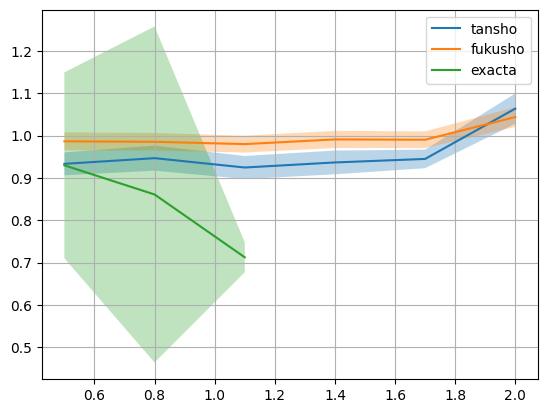

In [1488]:
importlib.reload(mev)
gain_tansho = gain.calc_return(mev.win_return)
gain_fukusho = gain.calc_return(mev.place_return)
gain_exacta = gain.calc_return(mev.exacta_return)

plot(gain_tansho, 'tansho')
plot(gain_fukusho, 'fukusho')
plot(gain_exacta, 'exacta')

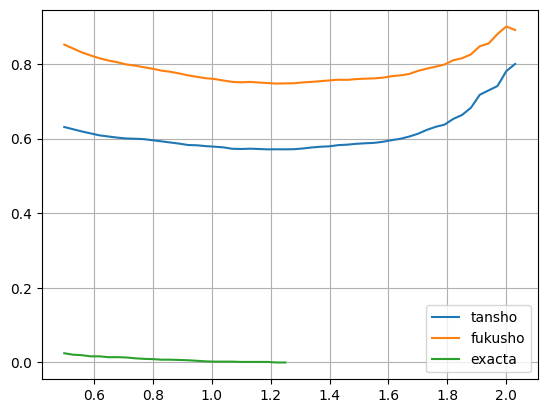

In [1431]:
# 的中率
plot_hit(gain_tansho, 'tansho')
plot_hit(gain_fukusho, 'fukusho')
plot_hit(gain_exacta, 'exacta')

In [1048]:
# シャープレシオのプロット
# plot_sharpratio(gain_tansho, 'tansho')
# plot_sharpratio(gain_fukusho, 'tansho')

## 実験

In [1457]:
import syusso_table as sy
import utils 
importlib.reload(sy)
importlib.reload(utils)

syusso = sy.SyussoTable(race_results, '20230105', 'OMR')
syusso.test()

20230105OMR01 直前情報リクエスト済みなのでスキップ
20230105OMR02 直前情報リクエスト済みなのでスキップ
20230105OMR03 直前情報リクエスト済みなのでスキップ
20230105OMR04 直前情報リクエスト済みなのでスキップ
20230105OMR05 直前情報リクエスト済みなのでスキップ
20230105OMR06 直前情報リクエスト済みなのでスキップ
20230105OMR07 直前情報リクエスト済みなのでスキップ
20230105OMR08 直前情報リクエスト済みなのでスキップ
20230105OMR09 直前情報リクエスト済みなのでスキップ
20230105OMR10 直前情報リクエスト済みなのでスキップ
20230105OMR11 直前情報リクエスト済みなのでスキップ
20230105OMR12 直前情報リクエスト済みなのでスキップ
syusso_table:テスト成功


In [800]:
# レーサーの過去テーブル作成テスト用(出走テーブルのデータをもとに作るのが処理時間が短くて確認しやすい
import racer_table as racer_t
importlib.reload(racer_t)

# hoge = racer_t.RacerTable.create_from_syusso(data_tables.race_t, syusso.data)
hoge = racer_t.RacerTable.create_from_syusso(syusso.race_results.data, syusso.data)
hoge.data_p

レーサーの過去生成データテーブルの作成


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 69.25it/s]


,レースコード,艇番,全国_1着率_allR,全国_3着率_allR,全国_着順平均_allR,全国_スタートタイミング_allR,全国_展示タイム_allR,当地_1着率_allR,当地_3着率_allR,当地_着順平均_allR,...,当地_1着率_5R,当地_3着率_5R,当地_着順平均_5R,当地_スタートタイミング_5R,当地_展示タイム_5R,コース別_1着率_5R,コース別_3着率_5R,コース別_着順平均_5R,コース別_スタートタイミング_5R,コース別_展示タイム_5R
0,20230105OMR01,1,0.138122,0.464088,3.417127,0.188483,6.819607,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.4,1.0,1.8,0.170,6.758
50,20230105OMR09,3,0.137741,0.465565,3.413223,0.188263,6.819916,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,0.8,2.6,0.226,6.846
1,20230105OMR01,2,0.076923,0.381538,3.778462,0.155556,6.829630,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.2,0.6,3.0,0.124,6.848
66,20230105OMR12,1,0.076687,0.380368,3.779141,0.155785,6.829846,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.2,0.8,2.4,0.186,6.818
2,20230105OMR01,3,0.248101,0.521519,3.288608,0.150128,6.873189,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.2,0.6,3.0,0.206,6.920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,20230105OMR12,3,0.286972,0.702465,2.691901,0.152852,6.784683,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.6,1.0,1.8,0.174,6.806
46,20230105OMR08,5,0.139108,0.485564,3.425197,0.179474,6.799921,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,0.2,4.2,0.220,6.832
47,20230105OMR08,6,0.144165,0.443936,3.686499,0.131648,6.794371,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,0.4,4.4,0.128,6.740
53,20230105OMR09,6,0.171698,0.584906,3.232075,0.170586,6.821096,0.0,0.0,NaN,...,0.0,0.0,NaN,NaN,NaN,0.0,0.2,4.6,0.244,6.810


In [964]:
import numpy as np
def win_payoff_list(df):
    # retval = []
    df = df[  
            (df['単勝_艇番']==df['艇番']) | 
            (df['単勝_艇番']==-1)
        ].copy()
    
    df['return'] = df['単勝_払戻金']
    return df
    
# 単勝
def win_return(pred_table, return_table):
    n_bets = len(pred_table)
    n_races = pred_table.index.nunique()
    money = -100 * n_bets
    df = return_table.copy() 
    df = df.merge(pred_table, left_index=True, right_index=True, how='right')
    
    hit_df = win_payoff_list(df)
    
    n_hits = len(hit_df)
    money += hit_df['return'].sum()
    std = hit_df['return'].groupby(level=0).sum().std() * np.sqrt(n_races) / (100 * n_bets)
        
    return n_bets, money, n_hits, std

In [963]:
def place_payoff_list(df):
    place_1 = df[  
            (df['複勝_1着_艇番']==df['艇番']) | 
            (df['複勝_1着_艇番']==-1)
        ].copy()
    place_1['return'] = place_1['複勝_1着_払戻金']
    
    place_2 = df[df['複勝_2着_艇番']==df['艇番']].copy()
    place_2['return'] = place_2['複勝_2着_払戻金']
    
    return pd.concat([place_1, place_2])
    

# 複勝
def place_return(pred_table, return_table):
    n_bets = len(pred_table)
    n_races = pred_table.index.nunique()
    money = -100 * n_bets
    df = return_table.copy() 
    df = df.merge(pred_table, left_index=True, right_index=True, how='right')
    
    hit_df = place_payoff_list(df)
    
    n_hits = len(hit_df)
    money += hit_df['return'].sum()
    std = hit_df['return'].groupby(level=0).sum().std() * np.sqrt(n_races) / (100 * n_bets)

    return n_bets, money, n_hits, std

In [1094]:

#	                艇番 pred 　　　bet	  exacta 		
#   20220528OMR06	1	 1.300359	1	   1-3
#   .....
#　 の形のテーブルになる
def pred_table_exacta_top_2(pred_table):
    # 新しくpred_tableをコピーしexacta行をつける
    exacta_pred_table = pred_table.copy()
    exacta_pred_table['exacta'] = ''

    # レースコードの数だけ試行
    for race_code in exacta_pred_table.index.unique():

        # レースコードごとのpred_table
        race_pred_table = pred_table.filter(regex=race_code, axis=0)
        if(len(race_pred_table) >= 2):
            # print(race_pred_table.sort_values('pred', ascending=False))
            # pred値が高い順にソートし、top2つだけ選ぶ
            df = race_pred_table.sort_values('pred', ascending=False)[:2]
            exacta_bet = df['艇番'].tolist()

            exacta_bet_str = '-'.join(map(str, exacta_bet))
            data = [''] * len(race_pred_table)
            data[0] = exacta_bet_str
            exacta_pred_table.loc[race_code, 'exacta'] = data

    exacta_pred_table = exacta_pred_table[exacta_pred_table['exacta'] != '']
    return exacta_pred_table

# 2連単
def exacta_payoff_list2(df):
    retval = []
    
    func = lambda _: _.map(lambda x: '-'.join(map(str, x)))
    evaluate_func = lambda x, y: x in y.split(',') 
    
    winning = []
    for i, row in df.iterrows():
        winning.append(row['2連単_艇番'] in row['exacta'])
    df['winning'] = winning 
    retval.append(df[df['winning']]['2連単_払戻金'])
       
    retval.append(df[df['2連単_艇番'] == -1]['2連単_払戻金'])
    return retval

def exacta_payoff_list(df):
    exacta_1 = df[  
            (df['2連単_艇番']==df['exacta']) | 
            (df['2連単_艇番']==-1)
        ].copy()
    exacta_1['return'] = exacta_1['2連単_払戻金']
    
    return exacta_1

# 2連単
def exacta_return(pred_table, return_table, buy_func=pred_table_exacta_top_2):
    df = return_table.copy() 
    
    pred_table = buy_func(pred_table.copy())
    df = df.merge(pred_table, left_index=True, right_index=True, how='right')
    
    n_bets = len(df)
    n_races = df.index.nunique()
    
    hit_df = exacta_payoff_list(df)
    
    n_hits = len(hit_df)
    
    money = -100 * n_bets
    money += hit_df['return'].sum()
    
    std = hit_df['return'].groupby(level=0).sum().std() * np.sqrt(n_races) / (100 * n_bets)
    
    return n_bets, money, n_hits, std

In [1095]:
df = exacta_return(gain_t.pred_tables[0.8], return_table.data_p)
df

(96, -2530, 18, 0.167734528360613)